In [1]:
import os

import matplotlib.pyplot
import matplotlib.pyplot as plt
import numpy
import numpy as np
import pandas
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import umap
from matplotlib.colors import LogNorm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (adjusted_rand_score, completeness_score,
                             homogeneity_score, mean_absolute_error,
                             normalized_mutual_info_score, r2_score,
                             silhouette_score)
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True

import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch.multiprocessing as mp

mp.set_start_method("spawn", force=True)

name = "Huber_lam"

In [2]:
%load_ext autoreload
%autoreload 2

from utils import *
from VAE_GDSC import GDSCDataset, GeneDrugVAE

In [3]:
cellline = pd.read_csv(
    "../dataset/gdsc/cellline_info.csv.gz",
    usecols=["COSMIC_ID", "SMILES", "NAME", "Z_score"],
)
exp = pd.read_csv("../dataset/gdsc/exp.csv.gz", index_col=0)

In [4]:
# 学習済みモデルの指定（ChemBERTa）
MODEL_NAME = "seyonec/ChemBERTa-zinc-base-v1"

# トークナイザーとモデルをロード
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

# GPUが使える場合はGPUに
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [5]:
smiles_list = cellline["SMILES"].unique().tolist()

inputs = tokenizer(smiles_list, padding=True, truncation=True, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]

In [6]:
drugs = pd.DataFrame(embeddings.cpu().numpy())
drugs.index = smiles_list

In [7]:
exp.index = exp.index.astype(str)
cellline["COSMIC_ID"] = cellline["COSMIC_ID"].astype(str)
drugs.index = drugs.index.astype(str)

In [8]:
exp_values = exp.to_numpy(dtype=np.float32)
cid_to_row = {cid: i for i, cid in enumerate(exp.index)}
drug_vec = {s: drugs.loc[s].to_numpy(dtype=np.float32) for s in drugs.index}
mask = cellline["COSMIC_ID"].isin(exp.index) & cellline["SMILES"].isin(drugs.index)
cellline_small = cellline.loc[mask].reset_index(drop=True)
print(f"usable pairs: {len(cellline_small):,} / {len(cellline):,}")

usable pairs: 284,826 / 284,826


In [9]:
print("n_sample:", cellline_small.shape[0])

n_sample: 284826


In [10]:
# そのまま/変更案
batch_size = 16384
num_epochs = 100

# まずはこのセットで様子見（20–30 epoch）
rec_w = 0.2  # 再構成の重みをさらに下げる
lam = 3.5  # 10.0 → 3.0（目安: 2〜5）
beta_max = 1.0  # KLを抑える項は一旦オフ
gamma = 2.0  # C に寄せる圧を強化（いまの4倍）

C_max = 0.05  # 0.10 → 0.05
C_steps = 200  # 100 → 200

lr = 1e-3
weight_decay = 1e-3

In [11]:
ds = GDSCDataset(
    cellline_small,
    exp_values,
    cid_to_row,
    drug_vec,
    dtype=torch.float32,
    pin_memory=True,
    copy_arrays=False,
    #     materialize="none",    # ← これが重要！前展開を完全禁止
    #     ram_limit_gb=0.5       # （任意）auto を使う時の安全枠も小さくできる
)

In [12]:
val_ratio = 0.2
n_total = len(ds)
n_val = int(n_total * val_ratio)
n_train = n_total - n_val

# 再現性
g = torch.Generator().manual_seed(42)
train_ds, val_ds = random_split(ds, [n_train, n_val], generator=g)

In [13]:
train_dl = DataLoader(
    train_ds,
    batch_size=batch_size,  # GPU メモリに合わせて調整（8k〜32k 目安）
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
    drop_last=True,
)

In [14]:
val_dl = DataLoader(
    val_ds,
    batch_size=batch_size,  # 余裕があれば少し大きめ
    shuffle=False,  # 検証はシャッフル不要
    num_workers=1,  # ここは少なめでもOK
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
    drop_last=False,
)

In [15]:
gene_dim = exp_values.shape[1]
smiles_dim = 768

device = (
    torch.device("cuda")
    if torch.cuda.is_available()
    else (
        torch.device("mps")
        if torch.backends.mps.is_available()
        else torch.device("cpu")
    )
)
device_type = (
    "cuda" if device.type == "cuda" else ("mps" if device.type == "mps" else "cpu")
)

use_amp = device_type in ("cuda", "mps")

# GradScaler は CUDA のみ
scaler = torch.amp.GradScaler(enabled=(device_type == "cuda"))

In [16]:
os.makedirs("models/gdsc", exist_ok=True)

best_val = float("inf")
best_path = f"models/gdsc/gdsc_best_{name}.pt"

# --- logs / histories ---
train_hist, val_hist, elbo_val_hist = [], [], []
train_rec_hist, train_kl_hist, train_z_hist = [], [], []
val_rec_hist, val_kl_hist, val_z_hist = [], [], []
train_capgap_hist, val_capgap_hist, C_values = [], [], []

model = GeneDrugVAE(
    gene_dim, drug_dim=smiles_dim, proj_dim=256, hidden=512, latent=128
).to(device)

# 1) Optimizer を param group で作り直し
head_params = list(model.head.parameters())
base_params = [p for n, p in model.named_parameters() if not n.startswith("head.")]

opt = torch.optim.Adam(
    [
        {"params": base_params, "lr": lr, "weight_decay": 1e-3},
        {"params": head_params, "lr": lr * 0.5, "weight_decay": 5e-3},  # ← LR↓, WD↑
    ]
)


def _avg(sum_val, cnt):
    return sum_val / max(cnt, 1)


beta_warmup_epochs = int(0.5 * num_epochs)
for ep in range(num_epochs):
    # === 追加：このepochのβ（0→1に線形） ===
    beta = beta_max * min(1.0, (ep + 1) / beta_warmup_epochs)

    model.train()
    C = C_max * (ep / C_steps) if ep < C_steps else C_max
    C_values.append(C)

    # ---- training ----
    m_total = n_batches = 0
    rec_sum = kl_sum = z_sum = capgap_sum = 0.0
    n_train_samples = 0

    for bidx, (xg, xd, y) in enumerate(
        tqdm(train_dl, desc=f"Train E{ep+1}", leave=False)
    ):
        if ep == 0 and bidx == 0:
            print(
                f"[LR] base={opt.param_groups[0]['lr']:.2e} | head={opt.param_groups[1]['lr']:.2e}"
            )

        xg = xg.to(device, non_blocking=True)
        xd = xd.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)

        with torch.amp.autocast(device_type=device_type, enabled=use_amp):
            recon, mu, lv, yhat = model(xg, xd)
            rec = F.mse_loss(recon, xg, reduction="mean")
            kl = 0.5 * (-1 - lv + mu.pow(2) + lv.exp()).sum(dim=1).mean()
            zloss = F.smooth_l1_loss(yhat, y, beta=1, reduction="mean")  # Huber
            gap_abs = torch.abs(kl - C)
            gap_sq = (kl - C) ** 2
            loss = rec_w * rec + beta * kl + gamma * gap_sq + lam * zloss

        if device_type == "cuda":
            prev_scale = scaler.get_scale()
            scaler.scale(loss).backward()
            scaler.unscale_(opt)  # ← これを追加してからクリップ
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(opt)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            opt.step()

        bs = xg.size(0)
        m_total += loss.item()
        n_batches += 1
        rec_sum += rec.item() * bs
        kl_sum += kl.item() * bs
        z_sum += zloss.item() * bs
        capgap_sum += gap_abs.item() * bs
        n_train_samples += bs

    train_loss = m_total / n_batches
    train_hist.append(train_loss)
    train_rec_hist.append(_avg(rec_sum, n_train_samples))
    train_kl_hist.append(_avg(kl_sum, n_train_samples))
    train_z_hist.append(_avg(z_sum, n_train_samples))
    train_capgap_hist.append(_avg(capgap_sum, n_train_samples))

    # ---- validation ----
    model.eval()
    val_loss_sum = 0.0
    n_val_batches = 0
    v_rec_sum = v_kl_sum = v_z_sum = v_capgap_sum = 0.0
    n_val_samples = 0
    elbo_val_sum = 0.0

    with torch.no_grad():
        for xg, xd, y in val_dl:
            xg, xd, y = xg.to(device), xd.to(device), y.to(device)
            recon, mu, lv, yhat = model(xg, xd)
            rec = F.mse_loss(recon, xg, reduction="mean")
            kl = 0.5 * (-1 - lv + mu.pow(2) + lv.exp()).sum(dim=1).mean()
            zloss = F.smooth_l1_loss(yhat, y, beta=1, reduction="mean")  # Huber
            gap_abs = torch.abs(kl - C)  # ← 追加：ログ用
            gap_sq = (kl - C) ** 2  # ← 追加：損失用（二乗）

            loss = rec_w * rec + beta * kl + gamma * gap_sq + lam * zloss
            elbo_loss = rec + beta * kl + lam * zloss

            bs = xg.size(0)
            val_loss_sum += loss.item()
            n_val_batches += 1
            v_rec_sum += rec.item() * bs
            v_kl_sum += kl.item() * bs
            v_z_sum += zloss.item() * bs
            v_capgap_sum += gap_abs.item() * bs  # ← 置換：capgap → gap_abs
            n_val_samples += bs
            elbo_val_sum += elbo_loss.item() * bs

    val_loss = val_loss_sum / n_val_batches
    val_hist.append(val_loss)
    val_rec_hist.append(_avg(v_rec_sum, n_val_samples))
    val_kl_hist.append(_avg(v_kl_sum, n_val_samples))
    val_z_hist.append(_avg(v_z_sum, n_val_samples))
    val_capgap_hist.append(_avg(v_capgap_sum, n_val_samples))
    elbo_val_hist.append(_avg(elbo_val_sum, n_val_samples))

    print(
        f"Epoch {ep+1}/{num_epochs} | Train {train_loss:.4f} | Val {val_loss:.4f} | Val(ELBO) {elbo_val_hist[-1]:.4f}"
    )

    print(
        f"  C={C:.3f} | "
        f"KL tr/val={train_kl_hist[-1]:.4f}/{val_kl_hist[-1]:.4f} | "
        f"gap(|KL-C|) tr/val={train_capgap_hist[-1]:.4f}/{val_capgap_hist[-1]:.4f} | "
        f"zloss tr/val={train_z_hist[-1]:.4f}/{val_z_hist[-1]:.4f} | "
        f"rec tr/val={train_rec_hist[-1]:.4f}/{val_rec_hist[-1]:.4f} | "
        f"beta={beta:.4f}, gamma={gamma:.4f}"
    )

    if (ep + 1) % 10 == 0:
        model.eval()
        eval_dl = torch.utils.data.DataLoader(
            val_ds,
            batch_size=8192,
            shuffle=False,
            num_workers=0,
            pin_memory=False,
            persistent_workers=False,
            drop_last=False,
        )
        ys, yhats = [], []
        with torch.inference_mode():
            for xg, xd, y in eval_dl:
                xg, xd = xg.to(device), xd.to(device)
                _, _, _, yhat = model(xg, xd)
                ys.append(y.cpu().numpy())
                yhats.append(yhat.cpu().numpy())
        import numpy as np
        from sklearn.metrics import mean_absolute_error, r2_score

        ys = np.concatenate(ys)
        yhats = np.concatenate(yhats)
        mae = mean_absolute_error(ys, yhats)
        r2 = r2_score(ys, yhats)
        print(f"  [Eval@E{ep+1}] MAE={mae:.4f}, R^2={r2:.4f}")
        print(f"  [Eval@E{ep+1}] yhat mean/std = {yhats.mean():.4f}/{yhats.std():.4f}")

    if val_loss < best_val - 1e-6:
        best_val = val_loss
        torch.save(model.state_dict(), best_path)
        print(f"[Save] Best model updated at epoch {ep+1}: {best_path}")

Train E1:   0%|          | 0/13 [00:00<?, ?it/s]

[LR] base=1.00e-03 | head=5.00e-04


Epoch 1/100 | Train 1.6325 | Val 1.5615 | Val(ELBO) 2.3406
  C=0.000 | KL tr/val=0.1096/0.1320 | gap(|KL-C|) tr/val=0.1096/0.1320 | zloss tr/val=0.3976/0.3777 | rec tr/val=1.0339/1.0160 | beta=0.0200, gamma=2.0000
[Save] Best model updated at epoch 1: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 2/100 | Train 1.5043 | Val 1.4609 | Val(ELBO) 2.2311
  C=0.000 | KL tr/val=0.1099/0.1299 | gap(|KL-C|) tr/val=0.1096/0.1296 | zloss tr/val=0.3637/0.3491 | rec tr/val=1.0093/1.0040 | beta=0.0400, gamma=2.0000
[Save] Best model updated at epoch 2: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 3/100 | Train 1.4225 | Val 1.4093 | Val(ELBO) 2.1918
  C=0.001 | KL tr/val=0.1145/0.0954 | gap(|KL-C|) tr/val=0.1140/0.0949 | zloss tr/val=0.3397/0.3387 | rec tr/val=1.0022/1.0008 | beta=0.0600, gamma=2.0000
[Save] Best model updated at epoch 3: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 4/100 | Train 1.3841 | Val 1.3798 | Val(ELBO) 2.1651
  C=0.001 | KL tr/val=0.0936/0.0865 | gap(|KL-C|) tr/val=0.0929/0.0857 | zloss tr/val=0.3312/0.3309 | rec tr/val=1.0002/0.9999 | beta=0.0800, gamma=2.0000
[Save] Best model updated at epoch 4: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 5/100 | Train 1.3638 | Val 1.3691 | Val(ELBO) 2.1633
  C=0.001 | KL tr/val=0.0766/0.0551 | gap(|KL-C|) tr/val=0.0756/0.0541 | zloss tr/val=0.3270/0.3309 | rec tr/val=0.9997/0.9997 | beta=0.1000, gamma=2.0000
[Save] Best model updated at epoch 5: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 6/100 | Train 1.3530 | Val 1.3517 | Val(ELBO) 2.1447
  C=0.001 | KL tr/val=0.0652/0.0629 | gap(|KL-C|) tr/val=0.0639/0.0617 | zloss tr/val=0.3248/0.3250 | rec tr/val=0.9999/0.9997 | beta=0.1200, gamma=2.0000
[Save] Best model updated at epoch 6: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 7/100 | Train 1.3327 | Val 1.3352 | Val(ELBO) 2.1284
  C=0.002 | KL tr/val=0.0604/0.0626 | gap(|KL-C|) tr/val=0.0589/0.0611 | zloss tr/val=0.3192/0.3200 | rec tr/val=0.9999/0.9997 | beta=0.1400, gamma=2.0000
[Save] Best model updated at epoch 7: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 8/100 | Train 1.3119 | Val 1.3400 | Val(ELBO) 2.1309
  C=0.002 | KL tr/val=0.0577/0.0686 | gap(|KL-C|) tr/val=0.0559/0.0669 | zloss tr/val=0.3133/0.3201 | rec tr/val=0.9997/0.9997 | beta=0.1600, gamma=2.0000


Epoch 9/100 | Train 1.3042 | Val 1.3133 | Val(ELBO) 2.1035
  C=0.002 | KL tr/val=0.0536/0.0716 | gap(|KL-C|) tr/val=0.0516/0.0696 | zloss tr/val=0.3112/0.3117 | rec tr/val=0.9995/0.9997 | beta=0.1800, gamma=2.0000
[Save] Best model updated at epoch 9: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 10/100 | Train 1.2817 | Val 1.2824 | Val(ELBO) 2.0775
  C=0.002 | KL tr/val=0.0516/0.0513 | gap(|KL-C|) tr/val=0.0494/0.0491 | zloss tr/val=0.3047/0.3050 | rec tr/val=0.9994/0.9997 | beta=0.2000, gamma=2.0000
  [Eval@E10] MAE=0.6460, R^2=0.2843
  [Eval@E10] yhat mean/std = 0.0266/0.5075
[Save] Best model updated at epoch 10: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 11/100 | Train 1.2657 | Val 1.2711 | Val(ELBO) 2.0670
  C=0.003 | KL tr/val=0.0486/0.0452 | gap(|KL-C|) tr/val=0.0461/0.0427 | zloss tr/val=0.3002/0.3021 | rec tr/val=0.9997/0.9997 | beta=0.2200, gamma=2.0000
[Save] Best model updated at epoch 11: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 12/100 | Train 1.2570 | Val 1.2653 | Val(ELBO) 2.0617
  C=0.003 | KL tr/val=0.0455/0.0440 | gap(|KL-C|) tr/val=0.0428/0.0413 | zloss tr/val=0.2978/0.3004 | rec tr/val=0.9997/0.9997 | beta=0.2400, gamma=2.0000
[Save] Best model updated at epoch 12: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 13/100 | Train 1.2468 | Val 1.2620 | Val(ELBO) 2.0581
  C=0.003 | KL tr/val=0.0422/0.0451 | gap(|KL-C|) tr/val=0.0392/0.0421 | zloss tr/val=0.2951/0.2990 | rec tr/val=0.9996/0.9997 | beta=0.2600, gamma=2.0000
[Save] Best model updated at epoch 13: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 14/100 | Train 1.2349 | Val 1.2540 | Val(ELBO) 2.0507
  C=0.003 | KL tr/val=0.0402/0.0431 | gap(|KL-C|) tr/val=0.0369/0.0399 | zloss tr/val=0.2917/0.2968 | rec tr/val=0.9997/0.9997 | beta=0.2800, gamma=2.0000
[Save] Best model updated at epoch 14: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 15/100 | Train 1.2357 | Val 1.2474 | Val(ELBO) 2.0446
  C=0.004 | KL tr/val=0.0379/0.0363 | gap(|KL-C|) tr/val=0.0344/0.0328 | zloss tr/val=0.2920/0.2954 | rec tr/val=0.9994/0.9997 | beta=0.3000, gamma=2.0000
[Save] Best model updated at epoch 15: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 16/100 | Train 1.2255 | Val 1.2331 | Val(ELBO) 2.0307
  C=0.004 | KL tr/val=0.0361/0.0334 | gap(|KL-C|) tr/val=0.0324/0.0296 | zloss tr/val=0.2891/0.2915 | rec tr/val=0.9996/0.9997 | beta=0.3200, gamma=2.0000
[Save] Best model updated at epoch 16: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 17/100 | Train 1.2123 | Val 1.2368 | Val(ELBO) 2.0356
  C=0.004 | KL tr/val=0.0343/0.0269 | gap(|KL-C|) tr/val=0.0303/0.0229 | zloss tr/val=0.2854/0.2933 | rec tr/val=0.9994/0.9997 | beta=0.3400, gamma=2.0000


Epoch 18/100 | Train 1.2053 | Val 1.2165 | Val(ELBO) 2.0146
  C=0.004 | KL tr/val=0.0320/0.0317 | gap(|KL-C|) tr/val=0.0277/0.0274 | zloss tr/val=0.2835/0.2867 | rec tr/val=0.9995/0.9997 | beta=0.3600, gamma=2.0000
[Save] Best model updated at epoch 18: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 19/100 | Train 1.1922 | Val 1.2156 | Val(ELBO) 2.0138
  C=0.004 | KL tr/val=0.0309/0.0355 | gap(|KL-C|) tr/val=0.0264/0.0310 | zloss tr/val=0.2797/0.2859 | rec tr/val=0.9999/0.9997 | beta=0.3800, gamma=2.0000
[Save] Best model updated at epoch 19: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 20/100 | Train 1.1819 | Val 1.2094 | Val(ELBO) 2.0073
  C=0.005 | KL tr/val=0.0292/0.0337 | gap(|KL-C|) tr/val=0.0244/0.0289 | zloss tr/val=0.2769/0.2840 | rec tr/val=0.9995/0.9997 | beta=0.4000, gamma=2.0000
  [Eval@E20] MAE=0.6159, R^2=0.3357
  [Eval@E20] yhat mean/std = 0.0390/0.6060
[Save] Best model updated at epoch 20: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 21/100 | Train 1.1750 | Val 1.2114 | Val(ELBO) 2.0106
  C=0.005 | KL tr/val=0.0290/0.0215 | gap(|KL-C|) tr/val=0.0240/0.0165 | zloss tr/val=0.2748/0.2862 | rec tr/val=0.9998/0.9997 | beta=0.4200, gamma=2.0000


Epoch 22/100 | Train 1.1653 | Val 1.1933 | Val(ELBO) 1.9921
  C=0.005 | KL tr/val=0.0272/0.0250 | gap(|KL-C|) tr/val=0.0219/0.0197 | zloss tr/val=0.2721/0.2804 | rec tr/val=0.9999/0.9997 | beta=0.4400, gamma=2.0000
[Save] Best model updated at epoch 22: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 23/100 | Train 1.1570 | Val 1.1822 | Val(ELBO) 1.9808
  C=0.006 | KL tr/val=0.0263/0.0254 | gap(|KL-C|) tr/val=0.0208/0.0199 | zloss tr/val=0.2697/0.2770 | rec tr/val=0.9997/0.9997 | beta=0.4600, gamma=2.0000
[Save] Best model updated at epoch 23: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 24/100 | Train 1.1523 | Val 1.1851 | Val(ELBO) 1.9839
  C=0.006 | KL tr/val=0.0256/0.0236 | gap(|KL-C|) tr/val=0.0198/0.0178 | zloss tr/val=0.2684/0.2780 | rec tr/val=0.9995/0.9997 | beta=0.4800, gamma=2.0000


Epoch 25/100 | Train 1.1411 | Val 1.1683 | Val(ELBO) 1.9665
  C=0.006 | KL tr/val=0.0250/0.0243 | gap(|KL-C|) tr/val=0.0190/0.0183 | zloss tr/val=0.2651/0.2728 | rec tr/val=0.9999/0.9997 | beta=0.5000, gamma=2.0000
[Save] Best model updated at epoch 25: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 26/100 | Train 1.1257 | Val 1.1675 | Val(ELBO) 1.9657
  C=0.006 | KL tr/val=0.0242/0.0232 | gap(|KL-C|) tr/val=0.0180/0.0169 | zloss tr/val=0.2607/0.2726 | rec tr/val=0.9994/0.9997 | beta=0.5200, gamma=2.0000
[Save] Best model updated at epoch 26: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 27/100 | Train 1.1341 | Val 1.1731 | Val(ELBO) 1.9719
  C=0.007 | KL tr/val=0.0236/0.0194 | gap(|KL-C|) tr/val=0.0171/0.0129 | zloss tr/val=0.2631/0.2748 | rec tr/val=0.9997/0.9997 | beta=0.5400, gamma=2.0000


Epoch 28/100 | Train 1.1293 | Val 1.1615 | Val(ELBO) 1.9596
  C=0.007 | KL tr/val=0.0232/0.0221 | gap(|KL-C|) tr/val=0.0165/0.0153 | zloss tr/val=0.2617/0.2707 | rec tr/val=0.9995/0.9997 | beta=0.5600, gamma=2.0000
[Save] Best model updated at epoch 28: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 29/100 | Train 1.1073 | Val 1.1440 | Val(ELBO) 1.9433
  C=0.007 | KL tr/val=0.0229/0.0208 | gap(|KL-C|) tr/val=0.0159/0.0138 | zloss tr/val=0.2553/0.2662 | rec tr/val=0.9996/0.9997 | beta=0.5800, gamma=2.0000
[Save] Best model updated at epoch 29: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 30/100 | Train 1.0941 | Val 1.1413 | Val(ELBO) 1.9402
  C=0.007 | KL tr/val=0.0229/0.0205 | gap(|KL-C|) tr/val=0.0157/0.0132 | zloss tr/val=0.2514/0.2652 | rec tr/val=0.9998/0.9997 | beta=0.6000, gamma=2.0000
  [Eval@E30] MAE=0.5901, R^2=0.3854
  [Eval@E30] yhat mean/std = 0.0044/0.6233
[Save] Best model updated at epoch 30: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 31/100 | Train 1.0894 | Val 1.1352 | Val(ELBO) 1.9339
  C=0.007 | KL tr/val=0.0215/0.0179 | gap(|KL-C|) tr/val=0.0140/0.0104 | zloss tr/val=0.2502/0.2637 | rec tr/val=1.0000/0.9997 | beta=0.6200, gamma=2.0000
[Save] Best model updated at epoch 31: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 32/100 | Train 1.0909 | Val 1.1355 | Val(ELBO) 1.9353
  C=0.008 | KL tr/val=0.0203/0.0171 | gap(|KL-C|) tr/val=0.0125/0.0093 | zloss tr/val=0.2508/0.2642 | rec tr/val=0.9999/0.9997 | beta=0.6400, gamma=2.0000


Epoch 33/100 | Train 1.0839 | Val 1.1322 | Val(ELBO) 1.9311
  C=0.008 | KL tr/val=0.0210/0.0203 | gap(|KL-C|) tr/val=0.0130/0.0123 | zloss tr/val=0.2485/0.2623 | rec tr/val=0.9996/0.9997 | beta=0.6600, gamma=2.0000
[Save] Best model updated at epoch 33: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 34/100 | Train 1.0682 | Val 1.1295 | Val(ELBO) 1.9290
  C=0.008 | KL tr/val=0.0200/0.0191 | gap(|KL-C|) tr/val=0.0117/0.0109 | zloss tr/val=0.2441/0.2618 | rec tr/val=0.9996/0.9997 | beta=0.6800, gamma=2.0000
[Save] Best model updated at epoch 34: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 35/100 | Train 1.0681 | Val 1.1222 | Val(ELBO) 1.9210
  C=0.009 | KL tr/val=0.0198/0.0192 | gap(|KL-C|) tr/val=0.0113/0.0107 | zloss tr/val=0.2440/0.2594 | rec tr/val=0.9997/0.9997 | beta=0.7000, gamma=2.0000
[Save] Best model updated at epoch 35: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 36/100 | Train 1.0690 | Val 1.1224 | Val(ELBO) 1.9210
  C=0.009 | KL tr/val=0.0197/0.0172 | gap(|KL-C|) tr/val=0.0110/0.0084 | zloss tr/val=0.2442/0.2597 | rec tr/val=0.9995/0.9997 | beta=0.7200, gamma=2.0000


Epoch 37/100 | Train 1.0586 | Val 1.1168 | Val(ELBO) 1.9157
  C=0.009 | KL tr/val=0.0200/0.0171 | gap(|KL-C|) tr/val=0.0110/0.0081 | zloss tr/val=0.2410/0.2581 | rec tr/val=0.9999/0.9997 | beta=0.7400, gamma=2.0000
[Save] Best model updated at epoch 37: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 38/100 | Train 1.0512 | Val 1.1038 | Val(ELBO) 1.9028
  C=0.009 | KL tr/val=0.0197/0.0155 | gap(|KL-C|) tr/val=0.0104/0.0062 | zloss tr/val=0.2389/0.2547 | rec tr/val=0.9999/0.9997 | beta=0.7600, gamma=2.0000
[Save] Best model updated at epoch 38: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 39/100 | Train 1.0478 | Val 1.1117 | Val(ELBO) 1.9099
  C=0.010 | KL tr/val=0.0175/0.0168 | gap(|KL-C|) tr/val=0.0080/0.0073 | zloss tr/val=0.2383/0.2563 | rec tr/val=0.9997/0.9997 | beta=0.7800, gamma=2.0000


Epoch 40/100 | Train 1.0444 | Val 1.1266 | Val(ELBO) 1.9247
  C=0.010 | KL tr/val=0.0173/0.0138 | gap(|KL-C|) tr/val=0.0076/0.0040 | zloss tr/val=0.2373/0.2611 | rec tr/val=0.9997/0.9997 | beta=0.8000, gamma=2.0000
  [Eval@E40] MAE=0.5847, R^2=0.3949
  [Eval@E40] yhat mean/std = 0.0293/0.6066


Epoch 41/100 | Train 1.0466 | Val 1.1090 | Val(ELBO) 1.9078
  C=0.010 | KL tr/val=0.0172/0.0176 | gap(|KL-C|) tr/val=0.0072/0.0076 | zloss tr/val=0.2379/0.2553 | rec tr/val=0.9992/0.9997 | beta=0.8200, gamma=2.0000


Epoch 42/100 | Train 1.0329 | Val 1.0950 | Val(ELBO) 1.8941
  C=0.010 | KL tr/val=0.0186/0.0142 | gap(|KL-C|) tr/val=0.0083/0.0039 | zloss tr/val=0.2335/0.2521 | rec tr/val=0.9996/0.9997 | beta=0.8400, gamma=2.0000
[Save] Best model updated at epoch 42: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 43/100 | Train 1.0395 | Val 1.1082 | Val(ELBO) 1.9073
  C=0.011 | KL tr/val=0.0188/0.0157 | gap(|KL-C|) tr/val=0.0083/0.0052 | zloss tr/val=0.2352/0.2555 | rec tr/val=0.9997/0.9997 | beta=0.8600, gamma=2.0000


Epoch 44/100 | Train 1.0259 | Val 1.1003 | Val(ELBO) 1.9000
  C=0.011 | KL tr/val=0.0174/0.0141 | gap(|KL-C|) tr/val=0.0066/0.0034 | zloss tr/val=0.2316/0.2537 | rec tr/val=0.9997/0.9997 | beta=0.8800, gamma=2.0000


Epoch 45/100 | Train 1.0171 | Val 1.0936 | Val(ELBO) 1.8924
  C=0.011 | KL tr/val=0.0181/0.0133 | gap(|KL-C|) tr/val=0.0071/0.0023 | zloss tr/val=0.2288/0.2516 | rec tr/val=0.9994/0.9997 | beta=0.9000, gamma=2.0000
[Save] Best model updated at epoch 45: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 46/100 | Train 1.0125 | Val 1.0889 | Val(ELBO) 1.8871
  C=0.011 | KL tr/val=0.0173/0.0132 | gap(|KL-C|) tr/val=0.0061/0.0019 | zloss tr/val=0.2276/0.2501 | rec tr/val=0.9995/0.9997 | beta=0.9200, gamma=2.0000
[Save] Best model updated at epoch 46: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 47/100 | Train 1.0075 | Val 1.0910 | Val(ELBO) 1.8902
  C=0.012 | KL tr/val=0.0184/0.0130 | gap(|KL-C|) tr/val=0.0069/0.0015 | zloss tr/val=0.2257/0.2509 | rec tr/val=0.9998/0.9997 | beta=0.9400, gamma=2.0000


Epoch 48/100 | Train 1.0009 | Val 1.0931 | Val(ELBO) 1.8923
  C=0.012 | KL tr/val=0.0163/0.0119 | gap(|KL-C|) tr/val=0.0045/0.0001 | zloss tr/val=0.2244/0.2518 | rec tr/val=0.9994/0.9997 | beta=0.9600, gamma=2.0000


Epoch 49/100 | Train 1.0071 | Val 1.0796 | Val(ELBO) 1.8789
  C=0.012 | KL tr/val=0.0163/0.0126 | gap(|KL-C|) tr/val=0.0043/0.0006 | zloss tr/val=0.2260/0.2477 | rec tr/val=0.9995/0.9997 | beta=0.9800, gamma=2.0000
[Save] Best model updated at epoch 49: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 50/100 | Train 0.9932 | Val 1.0891 | Val(ELBO) 1.8875
  C=0.012 | KL tr/val=0.0150/0.0115 | gap(|KL-C|) tr/val=0.0029/0.0007 | zloss tr/val=0.2223/0.2504 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E50] MAE=0.5693, R^2=0.4225
  [Eval@E50] yhat mean/std = 0.0206/0.6337


Epoch 51/100 | Train 1.0057 | Val 1.0824 | Val(ELBO) 1.8807
  C=0.013 | KL tr/val=0.0160/0.0121 | gap(|KL-C|) tr/val=0.0035/0.0004 | zloss tr/val=0.2257/0.2483 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000


Epoch 52/100 | Train 0.9855 | Val 1.0727 | Val(ELBO) 1.8717
  C=0.013 | KL tr/val=0.0160/0.0126 | gap(|KL-C|) tr/val=0.0034/0.0001 | zloss tr/val=0.2199/0.2455 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 52: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 53/100 | Train 0.9762 | Val 1.0755 | Val(ELBO) 1.8743
  C=0.013 | KL tr/val=0.0146/0.0129 | gap(|KL-C|) tr/val=0.0018/0.0001 | zloss tr/val=0.2176/0.2462 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 54/100 | Train 0.9759 | Val 1.0805 | Val(ELBO) 1.8788
  C=0.013 | KL tr/val=0.0153/0.0138 | gap(|KL-C|) tr/val=0.0021/0.0006 | zloss tr/val=0.2173/0.2472 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 55/100 | Train 0.9794 | Val 1.0758 | Val(ELBO) 1.8743
  C=0.014 | KL tr/val=0.0145/0.0126 | gap(|KL-C|) tr/val=0.0024/0.0009 | zloss tr/val=0.2185/0.2463 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000


Epoch 56/100 | Train 0.9750 | Val 1.0724 | Val(ELBO) 1.8711
  C=0.014 | KL tr/val=0.0155/0.0108 | gap(|KL-C|) tr/val=0.0036/0.0029 | zloss tr/val=0.2170/0.2459 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 56: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 57/100 | Train 0.9724 | Val 1.0800 | Val(ELBO) 1.8793
  C=0.014 | KL tr/val=0.0168/0.0119 | gap(|KL-C|) tr/val=0.0029/0.0021 | zloss tr/val=0.2159/0.2479 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 58/100 | Train 0.9628 | Val 1.0661 | Val(ELBO) 1.8649
  C=0.014 | KL tr/val=0.0168/0.0120 | gap(|KL-C|) tr/val=0.0038/0.0023 | zloss tr/val=0.2132/0.2438 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 58: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 59/100 | Train 0.9723 | Val 1.0741 | Val(ELBO) 1.8720
  C=0.014 | KL tr/val=0.0183/0.0123 | gap(|KL-C|) tr/val=0.0039/0.0022 | zloss tr/val=0.2155/0.2457 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 60/100 | Train 0.9593 | Val 1.0715 | Val(ELBO) 1.8703
  C=0.015 | KL tr/val=0.0152/0.0120 | gap(|KL-C|) tr/val=0.0023/0.0027 | zloss tr/val=0.2126/0.2453 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E60] MAE=0.5622, R^2=0.4345
  [Eval@E60] yhat mean/std = 0.0958/0.6801


Epoch 61/100 | Train 0.9533 | Val 1.0717 | Val(ELBO) 1.8699
  C=0.015 | KL tr/val=0.0152/0.0122 | gap(|KL-C|) tr/val=0.0027/0.0028 | zloss tr/val=0.2109/0.2452 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 62/100 | Train 0.9502 | Val 1.0740 | Val(ELBO) 1.8716
  C=0.015 | KL tr/val=0.0135/0.0115 | gap(|KL-C|) tr/val=0.0029/0.0037 | zloss tr/val=0.2105/0.2458 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 63/100 | Train 0.9414 | Val 1.0616 | Val(ELBO) 1.8602
  C=0.015 | KL tr/val=0.0146/0.0119 | gap(|KL-C|) tr/val=0.0016/0.0036 | zloss tr/val=0.2077/0.2424 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 63: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 64/100 | Train 0.9342 | Val 1.0631 | Val(ELBO) 1.8610
  C=0.016 | KL tr/val=0.0159/0.0112 | gap(|KL-C|) tr/val=0.0020/0.0046 | zloss tr/val=0.2052/0.2429 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 65/100 | Train 0.9304 | Val 1.0602 | Val(ELBO) 1.8579
  C=0.016 | KL tr/val=0.0145/0.0114 | gap(|KL-C|) tr/val=0.0028/0.0046 | zloss tr/val=0.2046/0.2420 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 65: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 66/100 | Train 0.9362 | Val 1.0604 | Val(ELBO) 1.8589
  C=0.016 | KL tr/val=0.0161/0.0112 | gap(|KL-C|) tr/val=0.0036/0.0051 | zloss tr/val=0.2057/0.2423 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 67/100 | Train 0.9288 | Val 1.0628 | Val(ELBO) 1.8625
  C=0.017 | KL tr/val=0.0145/0.0102 | gap(|KL-C|) tr/val=0.0037/0.0063 | zloss tr/val=0.2041/0.2436 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 68/100 | Train 0.9257 | Val 1.0822 | Val(ELBO) 1.8802
  C=0.017 | KL tr/val=0.0147/0.0103 | gap(|KL-C|) tr/val=0.0047/0.0065 | zloss tr/val=0.2032/0.2486 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 69/100 | Train 0.9227 | Val 1.0590 | Val(ELBO) 1.8574
  C=0.017 | KL tr/val=0.0142/0.0103 | gap(|KL-C|) tr/val=0.0035/0.0067 | zloss tr/val=0.2025/0.2421 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 69: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 70/100 | Train 0.9288 | Val 1.0602 | Val(ELBO) 1.8577
  C=0.017 | KL tr/val=0.0134/0.0111 | gap(|KL-C|) tr/val=0.0038/0.0061 | zloss tr/val=0.2044/0.2420 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E70] MAE=0.5569, R^2=0.4419
  [Eval@E70] yhat mean/std = 0.0735/0.6960


Epoch 71/100 | Train 0.9198 | Val 1.0530 | Val(ELBO) 1.8517
  C=0.017 | KL tr/val=0.0143/0.0113 | gap(|KL-C|) tr/val=0.0040/0.0062 | zloss tr/val=0.2016/0.2402 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 71: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 72/100 | Train 0.9151 | Val 1.0571 | Val(ELBO) 1.8558
  C=0.018 | KL tr/val=0.0135/0.0120 | gap(|KL-C|) tr/val=0.0055/0.0058 | zloss tr/val=0.2005/0.2412 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 73/100 | Train 0.9077 | Val 1.0828 | Val(ELBO) 1.8806
  C=0.018 | KL tr/val=0.0123/0.0109 | gap(|KL-C|) tr/val=0.0057/0.0071 | zloss tr/val=0.1987/0.2486 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 74/100 | Train 0.9161 | Val 1.0549 | Val(ELBO) 1.8530
  C=0.018 | KL tr/val=0.0138/0.0112 | gap(|KL-C|) tr/val=0.0062/0.0071 | zloss tr/val=0.2007/0.2406 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 75/100 | Train 0.9010 | Val 1.0554 | Val(ELBO) 1.8537
  C=0.018 | KL tr/val=0.0126/0.0108 | gap(|KL-C|) tr/val=0.0059/0.0077 | zloss tr/val=0.1967/0.2409 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000


Epoch 76/100 | Train 0.9052 | Val 1.0620 | Val(ELBO) 1.8617
  C=0.019 | KL tr/val=0.0127/0.0107 | gap(|KL-C|) tr/val=0.0061/0.0080 | zloss tr/val=0.1978/0.2432 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 77/100 | Train 0.9096 | Val 1.0620 | Val(ELBO) 1.8611
  C=0.019 | KL tr/val=0.0147/0.0117 | gap(|KL-C|) tr/val=0.0053/0.0073 | zloss tr/val=0.1986/0.2428 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 78/100 | Train 0.9021 | Val 1.0504 | Val(ELBO) 1.8491
  C=0.019 | KL tr/val=0.0149/0.0110 | gap(|KL-C|) tr/val=0.0044/0.0083 | zloss tr/val=0.1964/0.2395 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 78: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 79/100 | Train 0.8979 | Val 1.0582 | Val(ELBO) 1.8580
  C=0.020 | KL tr/val=0.0127/0.0105 | gap(|KL-C|) tr/val=0.0068/0.0090 | zloss tr/val=0.1958/0.2422 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 80/100 | Train 0.8943 | Val 1.0542 | Val(ELBO) 1.8529
  C=0.020 | KL tr/val=0.0122/0.0102 | gap(|KL-C|) tr/val=0.0076/0.0096 | zloss tr/val=0.1949/0.2409 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E80] MAE=0.5573, R^2=0.4502
  [Eval@E80] yhat mean/std = -0.0379/0.7025


Epoch 81/100 | Train 0.9011 | Val 1.0496 | Val(ELBO) 1.8478
  C=0.020 | KL tr/val=0.0110/0.0099 | gap(|KL-C|) tr/val=0.0090/0.0101 | zloss tr/val=0.1971/0.2395 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 81: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 82/100 | Train 0.8847 | Val 1.0458 | Val(ELBO) 1.8442
  C=0.020 | KL tr/val=0.0126/0.0103 | gap(|KL-C|) tr/val=0.0080/0.0100 | zloss tr/val=0.1920/0.2383 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 82: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 83/100 | Train 0.8831 | Val 1.0470 | Val(ELBO) 1.8457
  C=0.021 | KL tr/val=0.0144/0.0103 | gap(|KL-C|) tr/val=0.0073/0.0102 | zloss tr/val=0.1910/0.2388 | rec tr/val=0.9998/0.9997 | beta=1.0000, gamma=2.0000


Epoch 84/100 | Train 0.8848 | Val 1.0448 | Val(ELBO) 1.8437
  C=0.021 | KL tr/val=0.0127/0.0109 | gap(|KL-C|) tr/val=0.0081/0.0099 | zloss tr/val=0.1920/0.2380 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 84: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 85/100 | Train 0.8805 | Val 1.0483 | Val(ELBO) 1.8477
  C=0.021 | KL tr/val=0.0083/0.0102 | gap(|KL-C|) tr/val=0.0127/0.0108 | zloss tr/val=0.1920/0.2394 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 86/100 | Train 0.8885 | Val 1.0531 | Val(ELBO) 1.8522
  C=0.021 | KL tr/val=0.0134/0.0109 | gap(|KL-C|) tr/val=0.0078/0.0103 | zloss tr/val=0.1929/0.2404 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 87/100 | Train 0.8759 | Val 1.0467 | Val(ELBO) 1.8455
  C=0.022 | KL tr/val=0.0162/0.0103 | gap(|KL-C|) tr/val=0.0057/0.0112 | zloss tr/val=0.1885/0.2387 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 88/100 | Train 0.8691 | Val 1.0477 | Val(ELBO) 1.8467
  C=0.022 | KL tr/val=0.0121/0.0101 | gap(|KL-C|) tr/val=0.0096/0.0116 | zloss tr/val=0.1877/0.2391 | rec tr/val=0.9993/0.9997 | beta=1.0000, gamma=2.0000


Epoch 89/100 | Train 0.8770 | Val 1.0464 | Val(ELBO) 1.8455
  C=0.022 | KL tr/val=0.0131/0.0100 | gap(|KL-C|) tr/val=0.0089/0.0120 | zloss tr/val=0.1897/0.2388 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 90/100 | Train 0.8610 | Val 1.0579 | Val(ELBO) 1.8560
  C=0.022 | KL tr/val=0.0116/0.0111 | gap(|KL-C|) tr/val=0.0106/0.0112 | zloss tr/val=0.1855/0.2415 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E90] MAE=0.5574, R^2=0.4466
  [Eval@E90] yhat mean/std = 0.0789/0.7620


Epoch 91/100 | Train 0.8679 | Val 1.0456 | Val(ELBO) 1.8452
  C=0.023 | KL tr/val=0.0136/0.0105 | gap(|KL-C|) tr/val=0.0089/0.0120 | zloss tr/val=0.1869/0.2386 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 92/100 | Train 0.8674 | Val 1.0389 | Val(ELBO) 1.8389
  C=0.023 | KL tr/val=0.0139/0.0096 | gap(|KL-C|) tr/val=0.0089/0.0131 | zloss tr/val=0.1867/0.2370 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000
[Save] Best model updated at epoch 92: models/gdsc/gdsc_best_Huber_lam.pt


Epoch 93/100 | Train 0.8727 | Val 1.0579 | Val(ELBO) 1.8575
  C=0.023 | KL tr/val=0.0121/0.0107 | gap(|KL-C|) tr/val=0.0109/0.0123 | zloss tr/val=0.1887/0.2420 | rec tr/val=0.9996/0.9997 | beta=1.0000, gamma=2.0000


Epoch 94/100 | Train 0.8602 | Val 1.0517 | Val(ELBO) 1.8513
  C=0.023 | KL tr/val=0.0120/0.0103 | gap(|KL-C|) tr/val=0.0113/0.0130 | zloss tr/val=0.1852/0.2404 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000


Epoch 95/100 | Train 0.8592 | Val 1.0662 | Val(ELBO) 1.8667
  C=0.024 | KL tr/val=0.0134/0.0101 | gap(|KL-C|) tr/val=0.0101/0.0134 | zloss tr/val=0.1845/0.2448 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000


Epoch 96/100 | Train 0.8637 | Val 1.0464 | Val(ELBO) 1.8455
  C=0.024 | KL tr/val=0.0119/0.0105 | gap(|KL-C|) tr/val=0.0119/0.0133 | zloss tr/val=0.1862/0.2387 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000


Epoch 97/100 | Train 0.8571 | Val 1.0428 | Val(ELBO) 1.8421
  C=0.024 | KL tr/val=0.0151/0.0096 | gap(|KL-C|) tr/val=0.0089/0.0144 | zloss tr/val=0.1834/0.2379 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 98/100 | Train 0.8468 | Val 1.0434 | Val(ELBO) 1.8425
  C=0.024 | KL tr/val=0.0133/0.0096 | gap(|KL-C|) tr/val=0.0110/0.0146 | zloss tr/val=0.1810/0.2380 | rec tr/val=0.9994/0.9997 | beta=1.0000, gamma=2.0000


Epoch 99/100 | Train 0.8490 | Val 1.0469 | Val(ELBO) 1.8454
  C=0.025 | KL tr/val=0.0131/0.0095 | gap(|KL-C|) tr/val=0.0114/0.0150 | zloss tr/val=0.1816/0.2389 | rec tr/val=0.9997/0.9997 | beta=1.0000, gamma=2.0000


Epoch 100/100 | Train 0.8455 | Val 1.0474 | Val(ELBO) 1.8469
  C=0.025 | KL tr/val=0.0126/0.0094 | gap(|KL-C|) tr/val=0.0121/0.0154 | zloss tr/val=0.1808/0.2394 | rec tr/val=0.9995/0.9997 | beta=1.0000, gamma=2.0000
  [Eval@E100] MAE=0.5545, R^2=0.4534
  [Eval@E100] yhat mean/std = -0.0248/0.7278


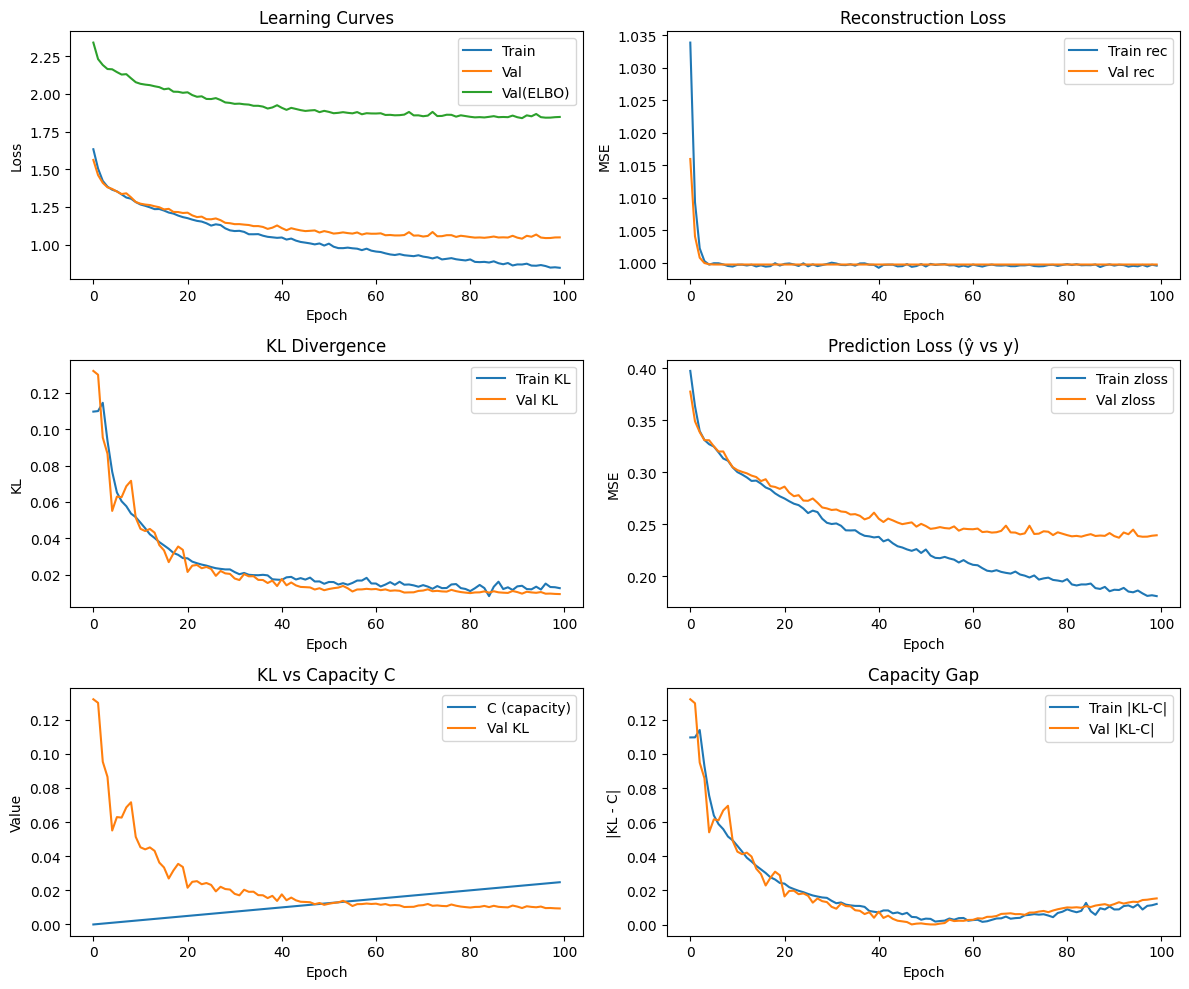

In [17]:
plot_all_curves(
    train_hist,
    val_hist,
    elbo_val_hist,
    train_rec_hist,
    val_rec_hist,
    train_kl_hist,
    val_kl_hist,
    train_z_hist,
    val_z_hist,
    C_values,
    train_capgap_hist,
    val_capgap_hist,
)

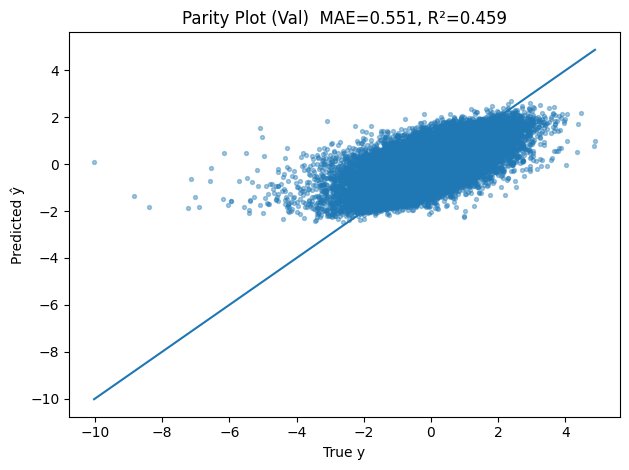

In [18]:
state = torch.load(best_path, map_location=device)
model.load_state_dict(state)
model.eval()  # 評価モード

eval_dl = torch.utils.data.DataLoader(
    val_ds,  # 元の val_ds でOK
    batch_size=8192,  # 好きなサイズ
    shuffle=False,
    num_workers=0,  # ★シングルプロセス
    pin_memory=False,  # ★不要
    persistent_workers=False,  # ★絶対 False
    drop_last=False,
)

ys, yhats = [], []
with torch.inference_mode():
    for xg, xd, y in eval_dl:
        xg, xd = xg.to(device), xd.to(device)
        _, _, _, yhat = model(xg, xd)
        ys.append(y.cpu().numpy())
        yhats.append(yhat.cpu().numpy())
ys = np.concatenate(ys)
yhats = np.concatenate(yhats)
mae = mean_absolute_error(ys, yhats)
r2 = r2_score(ys, yhats)

plt.figure()
plt.scatter(ys, yhats, s=8, alpha=0.4)
lims = [min(ys.min(), yhats.min()), max(ys.max(), yhats.max())]
plt.plot(lims, lims)
plt.xlabel("True y")
plt.ylabel("Predicted ŷ")
plt.title(f"Parity Plot (Val)  MAE={mae:.3f}, R²={r2:.3f}")
plt.tight_layout()
plt.show()

# How to eval from loading the model

In [19]:
# # 1. Build the model and load the trained weights
# model = GeneDrugVAE(gene_dim, drug_dim=768, proj_dim=256, hidden=512, latent=128).to(device)
# model.load_state_dict(torch.load("models/gdsc/gdsc_last.pt", map_location=device))
# model.eval()  # set to evaluation mode

# # 2. Extract latent representations (μ) for all samples
# mus = []
# with torch.no_grad():  # disable gradient computation
#     for xg, xd, _ in dl:   # ignore y (IC50), only need xg and xd
#         xg = xg.to(device, non_blocking=True)
#         xd = xd.to(device, non_blocking=True)
#         mu, lv = model.encode(xg, xd)   # encode gene + drug into latent space
#         mus.append(mu.cpu().numpy())    # collect μ on CPU

# # Concatenate all latent vectors into one array
# Z_mu = np.concatenate(mus, axis=0)
# print("Latent shape:", Z_mu.shape)

In [20]:
# # ---------- 1) 全サンプルの μ をバッチで抽出 ----------
# model.eval()
# mus = []
# with torch.no_grad():
#     # 推論用 DataLoader（shuffle=False）
#     infer_dl = DataLoader(ds, batch_size=8192, shuffle=False, num_workers=0)
#     for xg, xd, y in tqdm(infer_dl, desc="Encode (μ)", leave=False):
#         xg = xg.to(device, non_blocking=True)
#         xd = xd.to(device, non_blocking=True)
#         mu, logvar = model.encode(xg, xd)  # GeneDrugVAE で encode を実装している前提
#         mus.append(mu.cpu().numpy())

# Z_mu = np.concatenate(mus, axis=0)  # (N, latent)

In [21]:
# # 可視化用メタ：薬ラベル & Z_score（元の ds に対応する順序を確保）
# # cellline_small の順序が ds と一致している前提（Dataset 内でそのまま index を使っている実装ならOK）
# meta_df = cellline_small.reset_index(drop=True).copy()
# # NAME が無い場合は SMILES を代用
# drug_label = meta_df["NAME"] if "NAME" in meta_df.columns else meta_df["SMILES"]
# zscore = meta_df["Z_score"].values
# cellline = meta_df["COSMIC_ID"]

In [22]:
# X0 = StandardScaler(with_mean=True, with_std=True).fit_transform(Z_mu)
# X = (
#     PCA(n_components=min(100, X0.shape[1]), random_state=42)
#     .fit_transform(X0)
#     .astype("float32")
# )

# umap2d = umap.UMAP(
#     n_neighbors=40,
#     min_dist=0.05,
#     metric="cosine",
#     init="spectral",
#     densmap=True,
#     random_state=42,
#     low_memory=True,
#     verbose=True,
# ).fit_transform(X)

In [23]:
# plt.figure()
# sc = plt.scatter(umap2d[:, 0], umap2d[:, 1], s=6, c=zscore, alpha=0.7)
# cb = plt.colorbar(sc)
# cb.set_label("Z_score")
# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")
# plt.title("UMAP colored by Z_score")
# plt.tight_layout()
# plt.show()

In [24]:
# # 入力: umap2d (N,2), drug_label (N,), zscore (N,)
# labs = pd.Series(drug_label).astype(str).str.strip().values
# z = np.asarray(zscore, dtype=float)

# # 座標で集約（丸めて同一点判定）
# xy = np.round(umap2d, 6)
# df = pd.DataFrame({"x": xy[:, 0], "y": xy[:, 1], "drug": labs, "z": z})

# # 各座標で「z が最小の薬」を代表に採用（効きが強い薬）
# idx = df.groupby(["x", "y"])["z"].idxmin()
# rep = df.loc[idx].reset_index(drop=True)  # x,y,drug,z が 1行/座標

# # 可視化（Top-20 + Other）
# vc = rep["drug"].value_counts()
# top_k = 20
# top = list(vc.head(top_k).index)

# cmap = plt.colormaps.get_cmap("tab20")
# colors = {d: cmap(i / (top_k - 1)) for i, d in enumerate(top)}
# other_color = (0.5, 0.5, 0.5, 0.25)

# plt.figure(figsize=(9, 7))
# # Otherを下地に
# m_other = ~rep["drug"].isin(top)
# plt.scatter(
#     rep.loc[m_other, "x"],
#     rep.loc[m_other, "y"],
#     s=6,
#     alpha=0.30,
#     color=other_color,
#     rasterized=True,
#     zorder=1,
#     label="Other",
#     edgecolors="none",
# )
# # Top-20 を重ねる
# for d in top:
#     m = rep["drug"].values == d
#     if m.any():
#         plt.scatter(
#             rep.loc[m, "x"],
#             rep.loc[m, "y"],
#             s=12,
#             alpha=0.95,
#             color=colors[d],
#             label=d,
#             rasterized=True,
#             zorder=3,
#             edgecolors="none",
#         )

# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")
# plt.title("UMAP – winner-takes-all by drug (min Z_score)")
# plt.legend(
#     bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8, frameon=False, ncol=2
# )
# plt.tight_layout()
# plt.show()

In [25]:
# labs = pd.Series(drug_label).astype(str).str.strip().values
# drug = "Cisplatin"  # 例

# m = labs == drug
# plt.figure(figsize=(7, 6))
# plt.hexbin(umap2d[m, 0], umap2d[m, 1], gridsize=80, mincnt=1, norm=LogNorm())
# cb = plt.colorbar()
# cb.set_label("count (log)")
# plt.title(f"UMAP density – {drug}")
# plt.xlabel("UMAP 1")
# plt.ylabel("UMAP 2")
# plt.tight_layout()
# plt.show()